# **CNN+BLSTM**

**IMPORT PACKAGES AND LIBRARIES**

In [ ]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
from nltk import word_tokenize

**LOAD DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesiss/Spanish_merged_dataa.csv')

In [ ]:
data

,Unnamed: 0,Category,Text,clean_with_stopwords,final_clean
0,0,1,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",rae incluir el palabra lady en el diccionario ...,rae incluir palabra lady diccionario idioma es...
1,1,1,"La palabra ""haiga"", aceptada por la RAE La Rea...",el palabra haigar aceptado por el rae el real ...,palabra haigar aceptado rae real academia leng...
2,2,1,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,yordi rosado escribir y diseñar el nuevo libro...,yordi rosado escribir diseñar nuevo libro text...
3,3,0,UNAM capacitará a maestros para aprobar prueba...,unam capacitar a maestro para aprobar prueba p...,unam capacitar maestro aprobar prueba pis maxi...
4,4,1,Alerta: pretenden aprobar libros escolares con...,alerta pretender aprobar libro escolar con con...,alerta pretender aprobar libro escolar conteni...
...,...,...,...,...,...
2966,1995,0,El Consejo de Gobierno ha dado su visto bueno...,el consejo de gobierno haber dar su visto buen...,consejo gobierno haber dar visto bueno convoca...
2967,1996,0,Investigadores valencianos han desarrollado u...,investigador valenciano haber desarrollar uno ...,investigador valenciano haber desarrollar inno...
2968,1997,0,Los arrestados actuaban en coches y en establ...,el arrestado actuar en coche y en establecimie...,arrestado actuar coche establecimiento policia...
2969,1998,0,El Rey ha encargado este miércoles a Pedro Sá...,el rey haber encargar este miercoles a pedro s...,rey haber encargar miercoles pedro sanchez pre...


In [ ]:
data.drop(['Unnamed: 0', 'Text','clean_with_stopwords'], axis=1, inplace=True)  # Remove unnecessary columns

In [ ]:
docs = data.final_clean.values
labels = data.Category.values

**TOKENIZATION**

In [ ]:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1  # I add one because it starts counting from 0

In [ ]:
import nltk  # don't forget to do this step everytime in colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['Text_tokenised'] = data['final_clean'].apply(word_tokenize)

In [ ]:
data.head()

,Category,final_clean,Text_tokenised
0,1,rae incluir palabra lady diccionario idioma es...,"[rae, incluir, palabra, lady, diccionario, idi..."
1,1,palabra haigar aceptado rae real academia leng...,"[palabra, haigar, aceptado, rae, real, academi..."
2,1,yordi rosado escribir diseñar nuevo libro text...,"[yordi, rosado, escribir, diseñar, nuevo, libr..."
3,0,unam capacitar maestro aprobar prueba pis maxi...,"[unam, capacitar, maestro, aprobar, prueba, pi..."
4,1,alerta pretender aprobar libro escolar conteni...,"[alerta, pretender, aprobar, libro, escolar, c..."


In [ ]:
data['length'] = data['Text_tokenised'].str.len()

In [ ]:
maxlen = data['length'].max()

In [ ]:
maxlen

1391

**SPLIT DATA INTO TRAIN AND VALIDATE SETS**

In [ ]:
# divide the data into train/validate

from sklearn.model_selection import train_test_split


sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    docs, labels, test_size=0.2, random_state=1000)

In [ ]:
sentences_train

array(['propuesta salir adelante voto erc junts comu guanyem ejecutar espera informe juridicocompartir facebookcompartir twitterotroscerrarcompartir linkedincompartir pinterestver comentariosguardarimprimirb',
       'realizar paro facultad ciencia politica social unam estudiante protestar feminicidio acto acoso sexual reportar casa estudio realizar paro facultad ciencia politica social unam estudiante facultad ciencia politica social fcpys universidad nacional autonomo mexico unam tomar instalacion realizar paro hora protesta feminicidio acto acoso sexual reportar casa estudio pais primero hora viernes mujer facultad tomar control puerta plantel evitar trabajador academico estudiante poder ingresar comunicado universitaria señalar tras paro ayer jueves realizar mujer facultad filosofia letra tambien pararir actividad fcps argumentar universidad nacional ser cuna macho acosador violador protesta asesinato mujer dia registrar pais recordar caso lesvy berlin osorio joven aparecer muerto 

**CONVERT TEXTS TO SEQUENCES**

In [ ]:
# use keras tokenizer to turn train and valid to sequence


X_train = t.texts_to_sequences(sentences_train)
X_valid = t.texts_to_sequences(sentences_valid)


print(sentences_train[2])
print(X_train[2])

tension espejo publico atravesar pequeño pantalla susanna griso pretender mantener debate ordenado educado mañana enero asesor equipo campaña donald trump españa roberto centeno haber poner faci
[2501, 7201, 42, 2604, 279, 1649, 23372, 12593, 702, 178, 541, 4698, 6025, 315, 470, 1509, 79, 105, 372, 102, 76, 2136, 12408, 2, 60, 23373]


**APPLY POST-PADDING**

In [ ]:
# pad the short sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(X_train[1, :])

[  96 2236 1844 ...    0    0    0]


**EMBEDDING MATRIX**

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

**LOAD PRE-TRAINED WORD EMBEDDINGS**

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
        '/content/drive/MyDrive/thesiss/embeddings-l-model.vec',
        t.word_index, embedding_dim)

In [ ]:
# how many of the embedding vectors are nonzero

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8522880628143786

# **MODEL: CNN + BLSTM**

**BUILD THE MODEL**

In [ ]:
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam,SGD

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam=Adam(learning_rate=0.00001)
model1.compile(optimizer=adam,
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1357, 300)         7335900   
                                                                 
 dropout_18 (Dropout)        (None, 1357, 300)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1356, 64)          38464     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 339, 64)          0         
 1D)                                                             
                                                                 
 bidirectional_14 (Bidirecti  (None, 339, 80)          33600     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 80)              

**TRAIN THE MODEL**

In [ ]:
history = model1.fit(X_train, y_train,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=32)

Epoch 1/25
75/75 [==============================] - 12s 96ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 2/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6931 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5059
Epoch 3/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5076
Epoch 4/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6930 - accuracy: 0.5114 - val_loss: 0.6930 - val_accuracy: 0.4958
Epoch 5/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6930 - val_accuracy: 0.4941
Epoch 6/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6927 - accuracy: 0.5375 - val_loss: 0.6929 - val_accuracy: 0.5109
Epoch 7/25
75/75 [==============================] - 5s 70ms/step - loss: 0.6925 - accuracy: 0.5421 - val_loss: 0.6928 - val_accuracy: 0.5496
Epoch 8/25
7

**GRAPHIC REPRESENTATION**

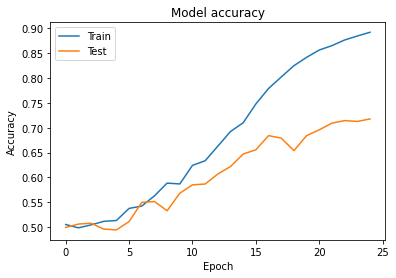

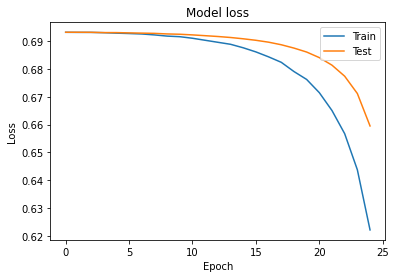

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

**METRICS**

In [ ]:
y_pred_valid=(model1.predict(X_valid)>0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid,y_pred_valid))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       291
           1       0.73      0.70      0.72       304

    accuracy                           0.72       595
   macro avg       0.72      0.72      0.72       595
weighted avg       0.72      0.72      0.72       595



In [ ]:
confusion_matrix(y_valid,y_pred_valid)

array([[214,  77],
       [ 91, 213]])

# **ATTEMPTING TO SOLVE OVERFITTING**

In [ ]:
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from keras.regularizers import l2

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam=Adam(learning_rate=0.00001) # 1e-5
model2.compile(optimizer=adam,
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1357, 300)         7335900   
                                                                 
 dropout_33 (Dropout)        (None, 1357, 300)         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 1356, 64)          38464     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 339, 64)          0         
 g1D)                                                            
                                                                 
 bidirectional_24 (Bidirecti  (None, 339, 80)          33600     
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 80)             

In [ ]:
from keras.callbacks import EarlyStopping  # THE MODEL IS STILL OVERFITTED
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
# fit the model on the whole data
history2 = model2.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=16,
                    callbacks=[es])# adding early stopping)

Epoch 1/50
149/149 [==============================] - 16s 69ms/step - loss: 1.1550 - accuracy: 0.5042 - val_loss: 1.1507 - val_accuracy: 0.4891
Epoch 2/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1460 - accuracy: 0.5063 - val_loss: 1.1420 - val_accuracy: 0.4891
Epoch 3/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1375 - accuracy: 0.5093 - val_loss: 1.1335 - val_accuracy: 0.4891
Epoch 4/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1290 - accuracy: 0.5063 - val_loss: 1.1252 - val_accuracy: 0.4891
Epoch 5/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1204 - accuracy: 0.5038 - val_loss: 1.1170 - val_accuracy: 0.4891
Epoch 6/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1121 - accuracy: 0.5118 - val_loss: 1.1089 - val_accuracy: 0.4891
Epoch 7/50
149/149 [==============================] - 9s 60ms/step - loss: 1.1039 - accuracy: 0.5101 - val_loss: 1.1009 - val_accuracy: 0.489

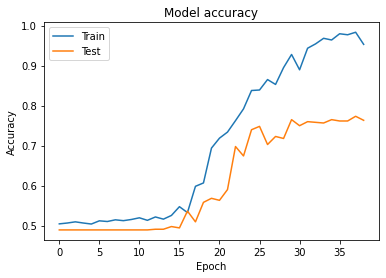

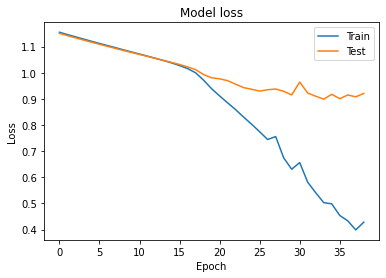

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

METRICS

In [ ]:
y_pred_valid2=(model2.predict(X_valid)>0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid,y_pred_valid2))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       291
           1       0.77      0.77      0.77       304

    accuracy                           0.76       595
   macro avg       0.76      0.76      0.76       595
weighted avg       0.76      0.76      0.76       595



In [ ]:
confusion_matrix(y_valid,y_pred_valid2)

array([[219,  72],
       [ 69, 235]])